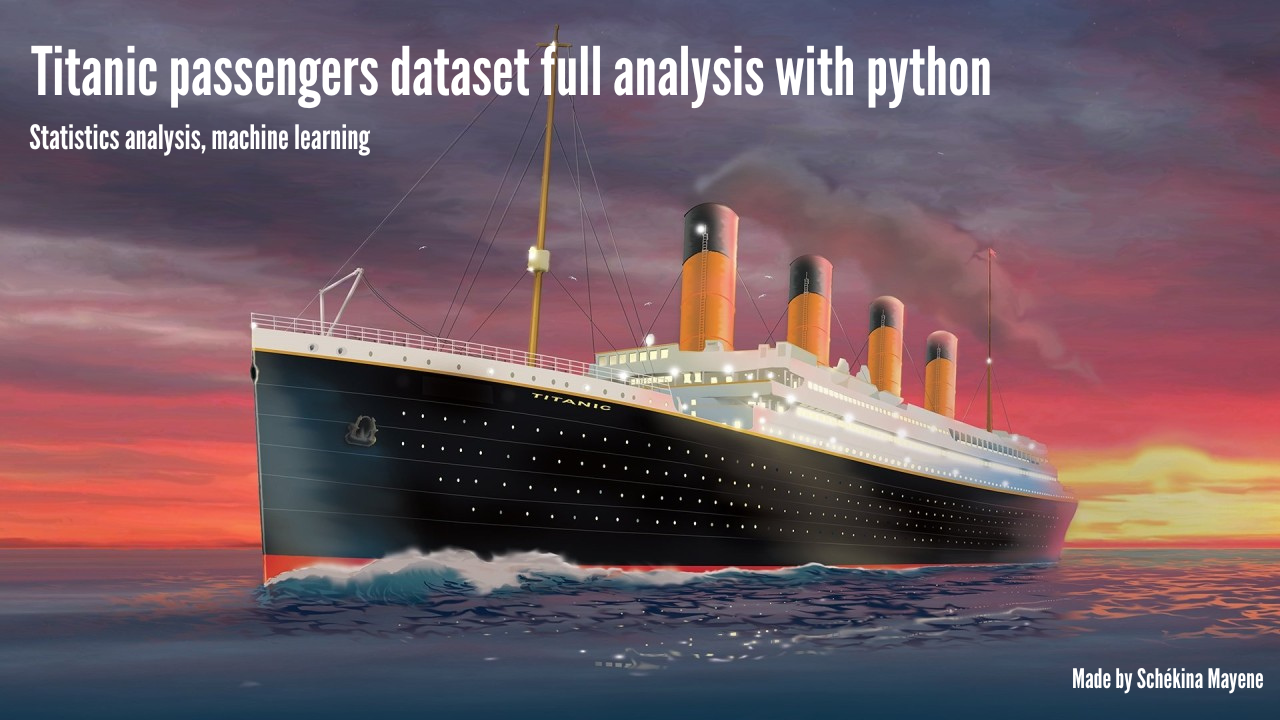

Dans ce cas d'étude nous travaillerons avec la base de données appelée **titanic**. Notre objectif sera de realiser des analyses sur cette base et de construire des modèles de machine learning dans le but de prédire la survie des passagers du bateau.

## Plan d'étude

**1-) *Inspection* et *nettoyage* du jeu de données**

**2-) Réalisations d'analyses univariées et bivariées**

**3-) Construction, évaluation et optimisation des modèles**

In [2]:
# chargment des libraries

import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import chi2_contingency, anderson, kstest, mannwhitneyu # test statistique
import statsmodels.formula.api as smf
import statsmodels.api as sm



In [183]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score, confusion_matrix, classification_report, accuracy_score, recall_score, precision_score

In [4]:
# importation de la première partie du dataset

titanic_train = pd.read_csv("train.csv", 
                       delimiter = ',',
                       header = 0)
# dimension
titanic_train.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


La base de données avec laquelle nous travaillerons est appelée **titanic**. Elle contient des informations relatives aux passagers du bateau du même nom

## Dictionnaire des variables 

**Pclass** :  Passenger Class (1 = 1st; 2 = 2nd; 3 = 3rd)

**survival** : Survival (0 = No; 1 = Yes)

**name** : Name

**sex** : Sex

**age** : Age

**sibsp** : Number of Siblings/Spouses Aboard (Nombre de frères et sœurs/conjoints à bord)

**parch** : Number of Parents/Children Aboard

**ticket** : Ticket Number

**fare** : Passenger Fare (British pound)

**cabin** : Cabin

**embarked** : Port of Embarkation (C = Cherbourg; Q = Queenstown; S = Southampton)

# 1-) Inspection et nettoyage

In [3]:
# Dimension de la base

titanic_train.shape

(891, 12)

In [4]:
titanic_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


**1-) Gestion des valeurs manquantes**

In [3]:
# Variables présentant des valeurs manquantes

pd.isnull(titanic_train).sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Nous constatons que nous avons des valeurs manquantes dans notre jeu de données.

>- La variable *cabin* possède seulement 204 enregistrements sur 891. Etant donné le nombre élevé de valeurs manquantes, nous décidons de supprimer cette variable pour le reste de notre étude.

>- Pour la variable *Embarked*, nous décidons de rempacer les valeurs manquantes par le mode de la variable

>- Pour la variable *age*, nous dédons d'impputer les valeurs manquantes de cette variable à l'aide de l'algorithme des K-Nearest Neighbours

In [5]:
# supression de la variable cabin

titanic_train.drop(columns = "Cabin", inplace = True)

In [6]:
# Remplacement des valeurs manquantes de la variable Embarked par le mode

titanic_train["Embarked"] = titanic_train["Embarked"].astype("category") #transformation du type de la variable pour effectuer l'imputation

mode_ = titanic_train["Embarked"].mode().iloc[0]


titanic_train["Embarked"].fillna(mode_, inplace = True)

 

In [7]:
# Remplacement des valeurs manquantes de la variable "age" 

imputer = KNNImputer(n_neighbors = 3) # choix du nombre de voisin

# Remodeler la colonne "Age" pour la rendre 2D
age_2d = titanic_train["Age"].values.reshape(-1, 1)


titanic_train["Age"] = imputer.fit_transform(age_2d) # ajustement des données aux données existentes

In [8]:
# Verification

titanic_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   PassengerId  891 non-null    int64   
 1   Survived     891 non-null    int64   
 2   Pclass       891 non-null    int64   
 3   Name         891 non-null    object  
 4   Sex          891 non-null    object  
 5   Age          891 non-null    float64 
 6   SibSp        891 non-null    int64   
 7   Parch        891 non-null    int64   
 8   Ticket       891 non-null    object  
 9   Fare         891 non-null    float64 
 10  Embarked     891 non-null    category
dtypes: category(1), float64(2), int64(5), object(3)
memory usage: 70.7+ KB


**2-) Recodage des variables catégorielles**

In [9]:
titanic_train.loc[titanic_train["Sex"] == "male", "Sex"] = 1
titanic_train.loc[titanic_train["Sex"] == "female", "Sex"] = 0

In [10]:
titanic_train["Embarked"] = titanic_train["Embarked"].astype("object")

titanic_train.loc[titanic_train["Embarked"] == "C", "Embarked"] = 0
titanic_train.loc[titanic_train["Embarked"] == "Q", "Embarked"] = 1
titanic_train.loc[titanic_train["Embarked"] == "S", "Embarked"] = 2


**Résumé des changements éffectués sur les variables catégorielles** 

>- **Variable Sex:** 

1 : Homme
0 : Femme

>- **Variable Embarked** 

0 : Cherbourg

1 : Queenstown

2 : Southampton

**3-) Changement du type des variables du jeu de données**

In [11]:
# Transformation des variables catégorielles

variables_cat = ['Survived','Pclass','Sex', 'Embarked']

for i in variables_cat :
    titanic_train[i] = titanic_train[i].astype('category')

In [12]:
# Transformation de la variable age en type "int64"

titanic_train['Age'] = titanic_train['Age'].astype('int64')

In [13]:
# Visualisation de toutes les transformtions effectuées
titanic_train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",1,22,1,0,A/5 21171,7.2500,2
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38,1,0,PC 17599,71.2833,0
2,3,1,3,"Heikkinen, Miss. Laina",0,26,0,0,STON/O2. 3101282,7.9250,2
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35,1,0,113803,53.1000,2
4,5,0,3,"Allen, Mr. William Henry",1,35,0,0,373450,8.0500,2
...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",1,27,0,0,211536,13.0000,2
887,888,1,1,"Graham, Miss. Margaret Edith",0,19,0,0,112053,30.0000,2
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",0,29,1,2,W./C. 6607,23.4500,2
889,890,1,1,"Behr, Mr. Karl Howell",1,26,0,0,111369,30.0000,0


# 2-) Analyses statistiques

## 2-1/ Analyses univariées

**Variables catégorielles :**

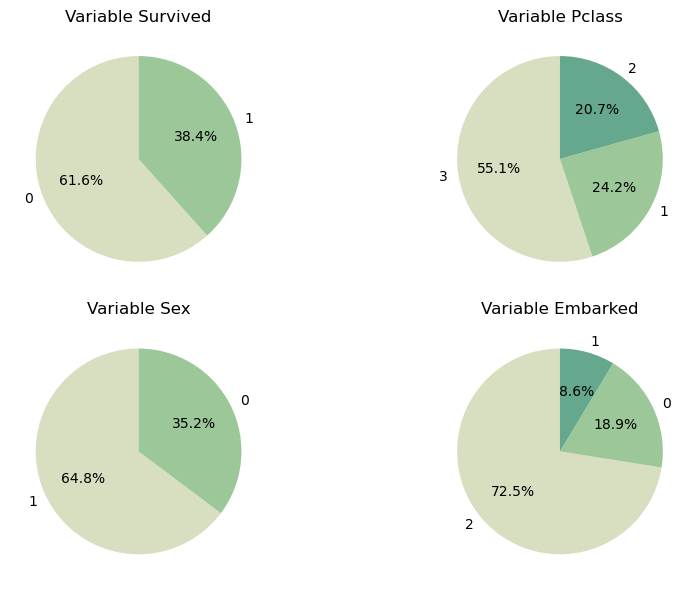

In [18]:
# diagramme circulaire des variables catégorielles d'une base de données

fig, axes = plt.subplots(2,2, figsize = (10,6))

# Aplatir le tableau d'axes
axes = axes.flatten()

for i, var in enumerate(variables_cat) :
    counts = titanic_train[var].value_counts()
    axes[i].pie(counts, labels = counts.index, autopct = "%1.1f%%", startangle = 90, colors = sns.cubehelix_palette(start=.5, rot=-.75))
    axes[i].set_title(f"Variable {var}")

    # Ajustements de la mise en page pour éviter les chevauchements
plt.tight_layout()
plt.show()

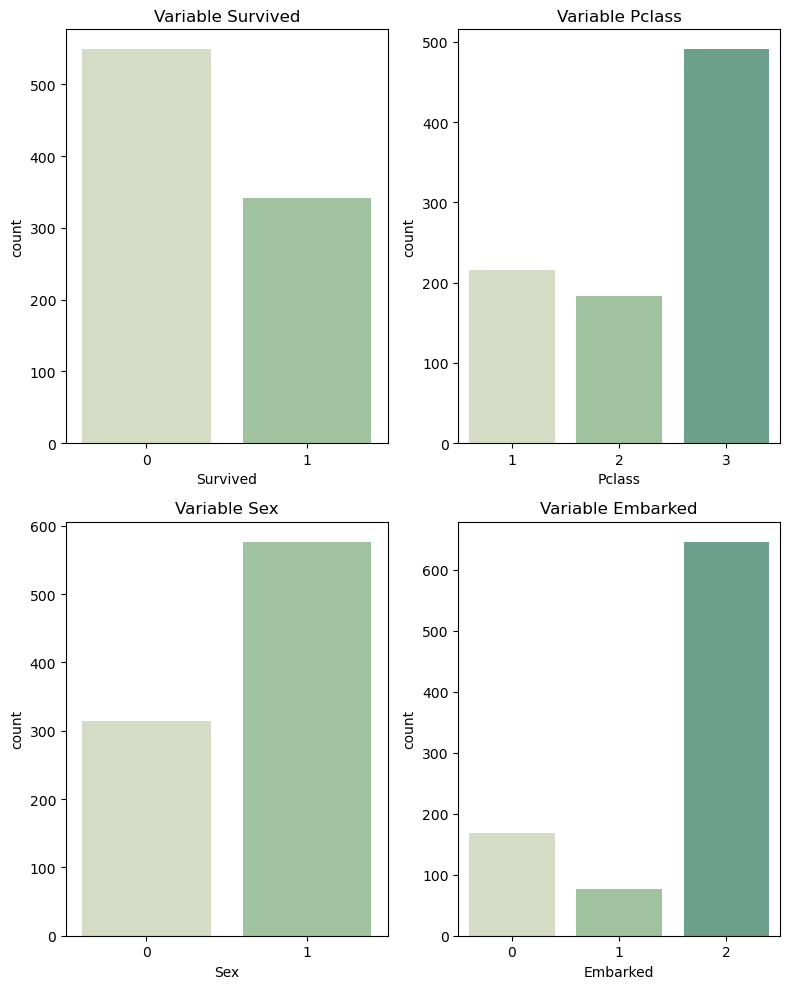

In [21]:
# Diagramme en barre des variables catégorielles de notre base de données

fig, axes = plt.subplots(2,2, figsize = (8,10))

axes = axes.flatten()

for i, var in enumerate(variables_cat) :
    counts = titanic_train[var].value_counts()
    sns.barplot(x = counts.index, y = counts, ax = axes[i], palette = sns.cubehelix_palette(start=.5, rot=-.75))
    axes[i].set_title(f"Variable {var}")
    
plt.tight_layout()

plt.show()

In [22]:
titanic_train["Survived"].value_counts()

Survived
0    549
1    342
Name: count, dtype: int64

**Commentaires :**

D'après les résultats obtenues ci-dessus, nous constatons que :

>- Près de 550 individus n'ont pas survecu au nauffrage du bâteau, ils représentent près de **61,6%** des individus de notre jeu de données
>- Un peu plus de la moitié des passagers voyageaient en 3ième classe
>- Les passagers sont composés majoritairement des hommes
>- **72,5%** des passagers ont embarqué sur la bâteau au port de Southampton

**Variables quantitatives** 

Pour ce type de variable, nous observerons comme graphique, des boites à moustache ainsi que des histogrammes

In [67]:
titanic_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   PassengerId  891 non-null    int64   
 1   Survived     891 non-null    category
 2   Pclass       891 non-null    category
 3   Name         891 non-null    object  
 4   Sex          891 non-null    category
 5   Age          891 non-null    int64   
 6   SibSp        891 non-null    int64   
 7   Parch        891 non-null    int64   
 8   Ticket       891 non-null    object  
 9   Fare         891 non-null    float64 
 10  Embarked     891 non-null    category
dtypes: category(4), float64(1), int64(4), object(2)
memory usage: 52.8+ KB


In [45]:
#Définissons nos variables quantitatives

variables_quant = ['Age', 'SibSp','Parch', 'Fare']

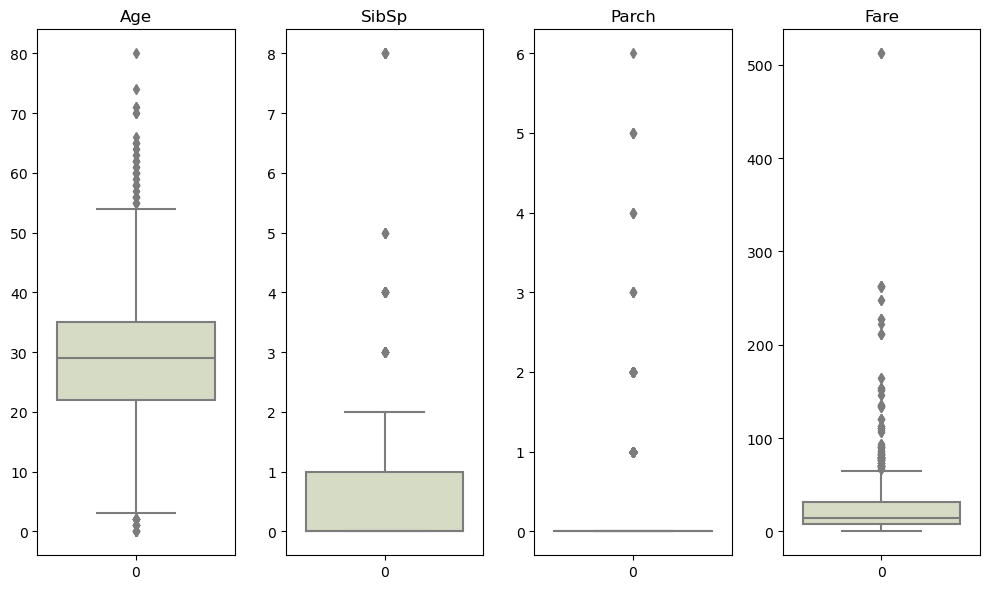

In [78]:
# Boîtes à moustache

fig, axes = plt.subplots(1,4 , figsize = (10,6))

axes = axes.flatten()

for i, var in enumerate(variables_quant) :
    sns.boxplot(titanic_train[var], ax = axes[i] , palette = sns.cubehelix_palette(start=.5, rot=-.75))
    axes[i].set_title(f"{var}")
    
plt.tight_layout()
plt.show()

In [74]:
titanic_train.loc[:, variables_quant].describe()

,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,891.000000
mean,29.544332,0.523008,0.381594,32.204208
std,13.013778,1.102743,0.806057,49.693429
min,0.000000,0.000000,0.000000,0.000000
25%,22.000000,0.000000,0.000000,7.910400
50%,29.000000,0.000000,0.000000,14.454200
75%,35.000000,1.000000,0.000000,31.000000
max,80.000000,8.000000,6.000000,512.329200


**Commentaires :**

Nous constatons que pour chacune de nos variables quantitatives, nous avons des valeurs extrêmes

>- En moyenne les passagers de notre jeux de données sont âgés de **29 ans**
>- 50% de ces passagers n'avaient pas de frères et soeurs (ou conjoint), ni d'enfants (ou parents) à l'interieur du bâteau 
>- 50% de ces passagers ont déboursé moins de 14.45 Livres pour acceder au bâteau


**Analysons la distribution de nos variables quantitatives**

Dans cette partie, nous tenterons de savoir si les distributions de nos variables quantitatives suivent une loi normale ou pas.
Pour cela, nous observerons :
>- Les histogrammes
>- Les QQ-plot
>- Les p-values des tests de normalité

C:\Users\mayen\AppData\Local\Temp\ipykernel_7156\2748828312.py:8: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(x = titanic_train[var], ax = axes[i], bins = 30, kde = True,
C:\Users\mayen\AppData\Local\Temp\ipykernel_7156\2748828312.py:8: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(x = titanic_train[var], ax = axes[i], bins = 30, kde = True,
C:\Users\mayen\AppData\Local\Temp\ipykernel_7156\2748828312.py:8: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(x = titanic_train[var], ax = axes[i], bins = 30, kde = True,
C:\Users\mayen\AppData\Local\Temp\ipykernel_7156\2748828312.py:8: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(x = titanic_train[var], ax = axes[i], bins = 30, kde = True,


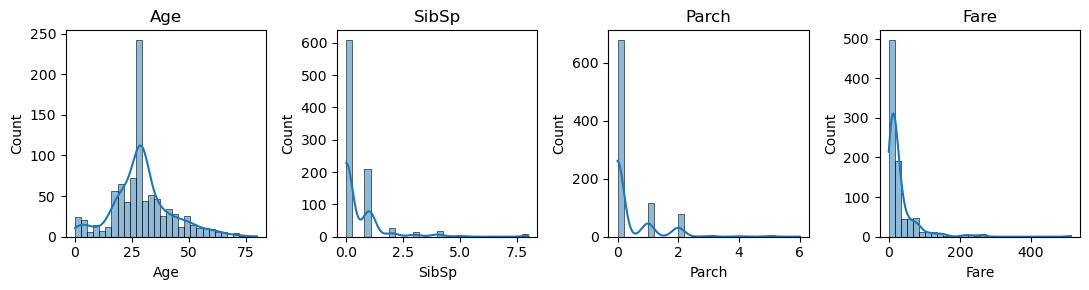

In [32]:
#Histogrammes

fig, axes = plt.subplots(1,4, figsize = (11,3))

axes = axes.flatten()

for i,var in enumerate(variables_quant) :
    sns.histplot(x = titanic_train[var], ax = axes[i], bins = 30, kde = True, 
                 palette = sns.cubehelix_palette(start=.5, rot=-.75))
    axes[i].set_title(var)
    
plt.tight_layout()
plt.show()

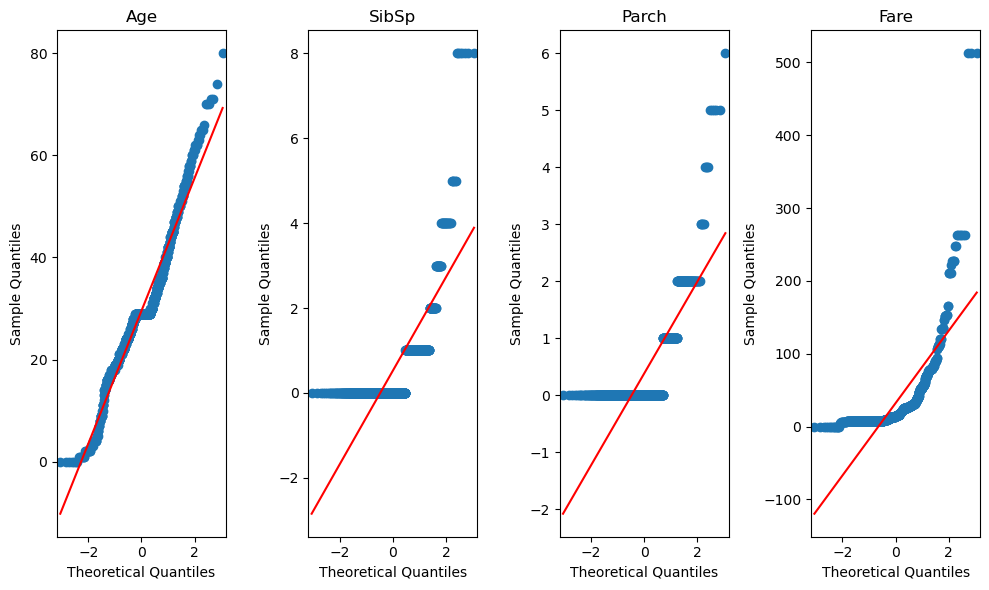

In [33]:
# QQ-PLOT

fig, axes = plt.subplots(1,4 , figsize = (10,6))

axes = axes.flatten()

for i, var in enumerate(variables_quant):
    sm.qqplot(titanic_train[var], line = 's', ax = axes[i])
    axes[i].set_title(var)
    
plt.tight_layout()
plt.show()

D'après les observations des graphiques ci-dessus, il semblerait que seul la variable "Age" suive une loi normale. Pour être certain de cela, nous effectuerons des test de normalité plus particulièrement celui d'**Anderson Darling** et celui de **Kolmogorov Smirnov** .

Les hypothèses des tests sont les suivantes :

**H0 : La distribution de la variable suit une loi normale** VS **H1 : La distribution de la variable ne suit pas une loi normale**

In [227]:
import pandas as pd
from scipy.stats import anderson, kstest

# Supposons que 'titanic_train' est votre DataFrame et que 'variables_quant' est la liste de vos variables quantitatives
test_normalite = pd.DataFrame(columns=["Variables", "Stat_Anderson", "Critical_value_Anderson", "Stat_KS", "P_value_KS"])

for var in variables_quant:
    resultats_anderson = anderson(titanic_train[var])
    stat_ks, p_value_ks = kstest(titanic_train[var], "norm")
    
    # Utilisation de critical_values pour extraire les p-valeurs correctes du test d'Anderson-Darling
    critical_value_anderson = resultats_anderson.critical_values[2]
    
    test_normalite.loc[len(test_normalite)] = [var,resultats_anderson.statistic, critical_value_anderson, stat_ks, p_value_ks]

# Affichage du dataframe
test_normalite


,Variables,Stat_Anderson,Critical_value_Anderson,Stat_KS,P_value_KS
0,Age,16.233515,0.784,0.971714,0.000000e+00
1,SibSp,147.364541,0.784,0.500000,1.679288e-206
2,Parch,175.658831,0.784,0.500000,1.679288e-206
3,Fare,122.169627,0.784,0.983135,0.000000e+00


In [225]:
# Test d'anderson
anderson(titanic_train["Age"])

AndersonResult(statistic=16.23351463555491, critical_values=array([0.573, 0.653, 0.784, 0.914, 1.087]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=29.544332210998878, scale=13.013778302447077)
 success: True
 message: '`anderson` successfully fit the distribution to the data.')

**Test d'Anderson** : 
Nous constatons que les statistiques de test pour toutes nos variables sont supérieures à la valeur critique correspondant à un seuil de significativité de 5% . De ce fait, nous rejettons l'hypothèse nulle de normalité. 

Nous constatons aussi que c'est la variable *Age* qui se rapproche le plus d'une distribution normale car elle a une statistique de test moins élevée.

**Test de Kolmogorov-Smirnov :**

La p-value associée au test est inférieur au seuil de 0,05 pour toutes nos variables. Comme pour le test précedent, nous rejettons l'hypothèse nulle de normalité.

## 2.2/ Analyses bivariées

**Variables quantitatives ~ Variables quantitatives**

Pour analyser les variables quantitatives entre elles, nous utiliserons une matrice de corrélation afin d'observer la liaison entre les variables

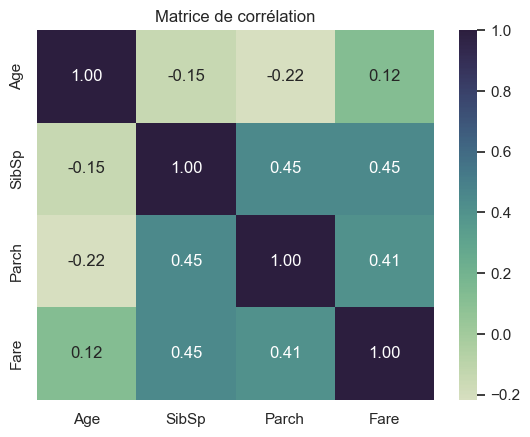

In [52]:
# Matrice de corrélation

matrix = titanic_train.loc[:, variables_quant].corr(method = "spearman")

sns.heatmap(matrix, annot = True, cmap = sns.cubehelix_palette(start=.5, rot=-.75, as_cmap=True), fmt = ".2f" )

plt.title("Matrice de corrélation")
plt.show()

Nous constatons qu'il n'existe que des faibles liaisons entre nos variables quantitatives. 

Nous pouvons quand même relever les informations suivantes :

>- Les passagers les plus âgés ont tendance à être ceux ayant le moins de frère et soeurs à bord du bâteau
>- Les passagers ayant le plus de frères et soeurs ont payer plus pour leur voyage

**Variables catégorielles ~ variable cible**

Pour ce type de variable, nous procéderons à un **test de Khi-deux** afin de mesurer l'indépendance entre nos variables catégorielles.

Les hypothèses du test sont les suivantes : 

**H0 : Les variables sont indépendantes** VS **H1 : Les variables sont dépendantes**

Si la p-value associée à ce test est inférieur au seuil de 0.05, nous rejetterons l'hypothèse nulle

In [53]:
# P_value et coef de Cramer

resultats = pd.DataFrame(columns = ["Nom_Var","Statistic_test", "P_value", "V_Cramer"])

for i in variables_cat:
    if i != "Survived" :
        contingency_table = pd.crosstab(titanic_train[i], titanic_train["Survived"])
        Statistic_test, P_value,_,_ = chi2_contingency(contingency_table)
            #calcul du V de cramer
        n = len(titanic_train)
        m = min(contingency_table.shape)-1
        V_cramer = np.sqrt(Statistic_test / (n*m))
                # Ajout des résultats dans le dataframe
        resultats.loc[len(resultats)] = [i , Statistic_test, P_value, V_cramer]
    
# Affichage 
resultats

,Nom_Var,Statistic_test,P_value,V_Cramer
0,Pclass,102.888989,4.549252e-23,0.339817
1,Sex,260.717020,1.197357e-58,0.540936
2,Embarked,25.964453,2.300863e-06,0.170707


**Commentaires :** 

Nous constatons que les p-values de toutes nos variables catégorielles sont inférieures au seuil de 5%. Nous rejettons alors les hypothèses nulles d'indépendance entre nos variables et notre variable cible "*Survived*"

Notons toutefois que ces liaisons ne sont pas très intenses.

La variable *Sex* est la variable ayant la plus forte liaison avec notre variable cible; En effet nous pouvons voir V_Cramer =**0,54**

**Variables quantitatives ~ Variable cible**

L'idée dans cette partie serait de voir s'il existe des différences entre les survivants et les non survivants. Pour cela nous observerons : 
>- Les histogrammes de nos variables quantitatives selon notre variable cible "Survived"
>- Les resultats du test de **Mann Whitney**

In [118]:
variables_quant

['Age', 'SibSp', 'Parch', 'Fare']

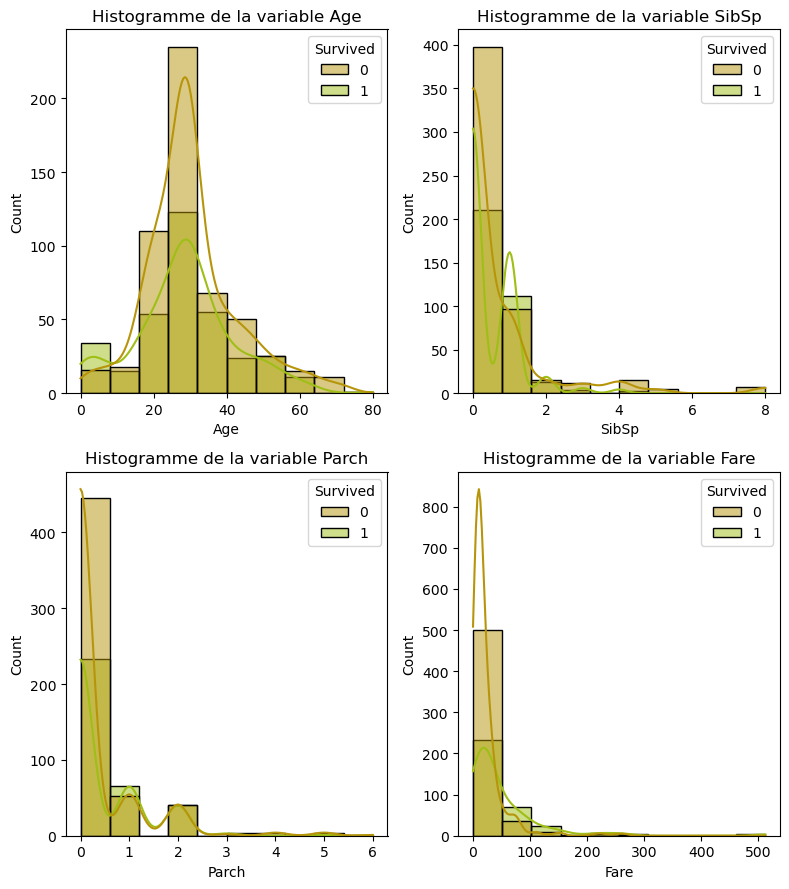

In [235]:
fig, axes = plt.subplots(2,2, figsize= (8,9))

axes = axes.flatten()

for i, var in enumerate(variables_quant):
    sns.histplot(x = titanic_train[var], bins = 10, kde = True, hue = titanic_train["Survived"], ax = axes[i], 
                 palette = ["#B7950B", "#9FBE16"] )
    axes[i].set_title(f"Histogramme de la variable {var}")
plt.tight_layout()
plt.show()

Sur les graphiques ci-dessus, nous observons pas réellement de différence entre les survivants et les non survivants. 

Nous allons alors donc effectuer un test de Mann Whitney étant donné que nos variables ne suivent pas une loi normale.

Hypothèse du test :

**H0 :  Les distributions des deux échantillons sont égales** VS **H1 :  Les distributions des deux échantillons sont différentes (Pour une alternative 'two-sided')**

In [58]:
res = pd.DataFrame(columns = ["Var", "Stat", "P_value"])

for var in variables_quant:
    group1 = titanic_train.loc[titanic_train["Survived"]== 1, var]
    group2 = titanic_train.loc[titanic_train["Survived"]== 0, var]
    stat, pvalue = mannwhitneyu(group1, group2, alternative='two-sided')
    res.loc[len(res)] = [var, stat, pvalue]
    
# Affichage
res

,Var,Stat,P_value
0,Age,89776.0,2.694596e-01
1,SibSp,101983.0,8.016684e-03
2,Parch,105373.0,3.712491e-05
3,Fare,129951.5,4.553477e-22


Pour chacune les variables SibSp, Parch et Fare, nous observons que la p-value est inférieur au seuil de 5%. Nous rejettons donc l'hypothèse nulle pour ces variables

Pour la variable Age par contre, la p-value est > au seuil de 0.05, Nous ne pouvons donc pas rejetter l'hypothèse nulle d'égalité entre les distributions de nos deux échantillons (les survivants et les non survivants). L'âge semble différencier alors nos deux groupes.

# 3-) Machine Learning

## 3-1 -) Apprentissage supervisée avec l'algorithme des K-NN

Nous utiliserons le modèle K-Neirest Neighbors afin de prédire la survie des passagers du bâteau. 

**Division du Dataset**

In [31]:
# Noms des colonnes du dataset
titanic_train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Embarked'],
      dtype='object')

In [169]:
### Division du jeu de données en train et test set

features = titanic_train.loc[:, ['Pclass', 'Sex', 'Age', 'SibSp',
       'Parch','Fare', 'Embarked']]

target = titanic_train["Survived"]

In [170]:
features_train, features_test,target_train, target_test = train_test_split(features, target, test_size = 0.2, 
                                                                            random_state = 42)

In [35]:
# Inspection des données

features_train.shape

(712, 7)

In [36]:
features_test.shape

(179, 7)

Nous aurons donc pour notre modèl, *712 enregistrements* pour notre jeu de données d'entrainnement contre *179 enregistrements* pour notre jeu de données de test. 

**Standardisation :**

Avant de pouvoir effectuer la mise en place de notre algorithme de K-NN, Nous allons standardiser nos variables quantitatives. 

Cette étape nous permettra de palier à la différence de grandeur existante entre nos variables (l'âge et le nombre de frères et soeurs par exemple. Celle-ci (la distance) peut avoir un impact dans le calcul des distances par l'algorithme.

In [171]:
# Standardisation

standard = StandardScaler()

features_train[variables_quant] = standard.fit_transform(features_train[variables_quant])
features_test[variables_quant] = standard.transform(features_test[variables_quant])

In [172]:
# Apperçue du résultat
features_train

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
331,1,1,1.201713,-0.470722,-0.479342,-0.078684,2
733,2,1,-0.491364,-0.470722,-0.479342,-0.377145,2
382,3,1,0.201258,-0.470722,-0.479342,-0.474867,2
704,3,1,-0.260490,0.379923,-0.479342,-0.476230,2
813,3,0,-1.799652,2.931860,2.048742,-0.025249,2
...,...,...,...,...,...,...,...
106,3,0,-0.645281,-0.470722,-0.479342,-0.480162,2
270,1,1,-0.029616,-0.470722,-0.479342,-0.030545,2
860,3,1,0.893881,1.230569,-0.479342,-0.355804,2
435,1,0,-1.183987,0.379923,2.048742,1.683201,2


**Construction, entrainement et prédictions**

Pour ce premier model, nous prenons k = sqrt(nombre de features). Nous ajusterons ensuite notre modèle plus tard à l'aide de la GridSearchCV

In [174]:
# Nombre de voisin de départ
np.sqrt(features.shape[1])

2.6457513110645907

In [175]:
# Construction du model 1

Knn_model1 = KNeighborsClassifier(3)

#Entrainement du model
Knn_model1.fit(features_train, target_train)

KNeighborsClassifier(n_neighbors=3)

In [180]:
# Prédictions
target_pred = Knn_model1.predict(features_test)

(179,)

**Evaluation du model**

In [177]:
# Accuracy

accuracy_score(target_test, target_pred)

0.8044692737430168

**Interpretation :** 

Nous constatons un accuracy_score à **0.8044**.Cela signifie que notre modèle classe 80% des enregistrements de notre dataset correctement. 

Cependant,la repartition entre les survivants et les non survivants n'est pas équilibrée. Nous ne pouvons pas nous apppuyer sur l'accuracy pour évaluer les performances de notre modèle. 

Nous utiliserons donc des métriques telles que la precision, le recall, le f1 score et la matrice de confusion

Text(0.5, 1.0, 'Confusion Matrix')

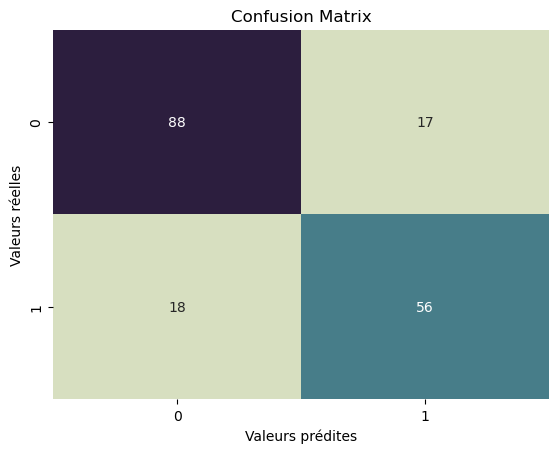

In [179]:
# Confusion matrix
conf_matrix = confusion_matrix(target_test, target_pred)

sns.heatmap(conf_matrix, annot = True, cbar= False , cmap =sns.cubehelix_palette(start=.5, rot=-.75) )
plt.ylabel("Valeurs réelles")
plt.xlabel("Valeurs prédites")
plt.title("Confusion Matrix")

In [181]:
# Vérifions quelles classes sont considérées comme positives et négatives
positive_class = Knn_model1.classes_[1]
negative_class = Knn_model1.classes_[0]

print(f"Classe Positive : {positive_class}")
print(f"Classe Négative : {negative_class}")

Classe Positive : 1
Classe Négative : 0


**Rappel :**

1 = Survivant

0 = Non survivant

In [184]:
# Métriques d'évaluation

a = precision_score(target_test, target_pred)
b = recall_score(target_test, target_pred)
c = f1_score(target_test, target_pred)

print(f"precision :  {a}")
print(f"recall : {b}")
print(f" f1_score : {c}")

precision :  0.7671232876712328
recall : 0.7567567567567568
 f1_score : 0.761904761904762


**Interpretation :** 

>- precision = **0.767** :
  Parmis nos prédictions positives, nous avons réussi à predire correctement 76% des individus qui ont survécu
  
>- recall =  **0.756** :
Nous pouvons donc dire que notre modèle a réussi à capturer 75.7% de tous les survivants présents dans les données.

>- f1_score = **0.7619** :
 Un F1-score de 76.2% indique une performance globale relativement bonne, en tenant compte à la fois des faux positifs et des faux négatifs. 

**Optimisation du model**

**1-/ Cross-Validation**

Dans cette partie, nous éssayerons d'observer comment varie le f1_score en fonction des différentes valeurs de k (= Nombre de voisin) à l'aide d'un graphique

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


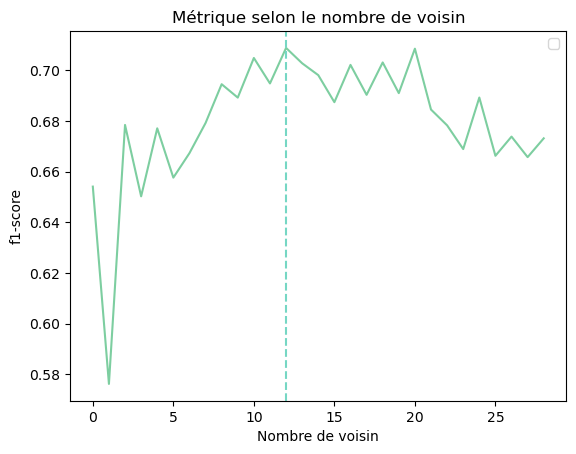

In [198]:
k_values = []

for i in range(1,30):
    score = cross_val_score(KNeighborsClassifier(i), features_train, target_train, cv = 5, scoring = 'f1').mean()
    k_values.append(score)
    
plt.plot(k_values, color = '#7DCEA0')

plt.xlabel('Nombre de voisin')
plt.ylabel('f1-score')

# Trouver la position du maximum dans la liste k_values
max_index = k_values.index(max(k_values))

plt.title('Métrique selon le nombre de voisin')

plt.axvline(x = max_index, color = '#76D7C4', linestyle = '--')
plt.legend()
plt.show()
    

**2-/ GridSearchCV**

In [194]:
# Création de la grille

params = {'n_neighbors' : np.arange(1,25),
               'metric' : ['euclidean', 'manhattan', 'minkowski']}

grid = GridSearchCV(estimator = KNeighborsClassifier(), param_grid = params , scoring = 'f1',   cv =5)

# Entrainement
grid.fit(features_train, target_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'metric': ['euclidean', 'manhattan', 'minkowski'],
                         'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24])},
             scoring='f1')

In [195]:
# Meilleurs paramètres et meilleur score

print("Meilleurs paramètres :",grid.best_params_)
print("Meilleur score :", grid.best_score_)

Meilleurs paramètres : {'metric': 'manhattan', 'n_neighbors': 13}
Meilleur score : 0.7315697648291625


D'après le resultat de la GridSeachCV, nous voyons que nos paramètres optimaux sont :

>- 13 pour le nombre de voisin,
>- Manhattan pour le type de distance à choisir entre les voisins

Nous construisons alors, notre 2e model

In [196]:
# Model 2
Knn_model2 = KNeighborsClassifier( n_neighbors = 13, metric = 'manhattan')

#Entrainement du model
Knn_model2.fit(features_train, target_train)

KNeighborsClassifier(metric='manhattan', n_neighbors=13)

In [197]:
# Prédictions et évaluation
target_pred2 = Knn_model2.predict(features_test)

f1_score(target_test, target_pred2)

0.7857142857142858

**Commentaires :** Nous constatons une amélioration de la valeur de notre f1_score. Nous passons de 76% à 78% de performance globale de notre modèle

# Test

Dans l'optique de voir si les performances de notre model s'améliore, nous allons éssayer de refaire notre modélisation avec cette fois-ci un encodage one hot de nos variables catégorielles

In [127]:
titanic_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   PassengerId  891 non-null    int64   
 1   Survived     891 non-null    category
 2   Pclass       891 non-null    category
 3   Name         891 non-null    object  
 4   Sex          891 non-null    category
 5   Age          891 non-null    int64   
 6   SibSp        891 non-null    int64   
 7   Parch        891 non-null    int64   
 8   Ticket       891 non-null    object  
 9   Fare         891 non-null    float64 
 10  Embarked     891 non-null    category
dtypes: category(4), float64(1), int64(4), object(2)
memory usage: 52.8+ KB


In [206]:
# Transformons nos variables catégorielles en variables binaires (Encodage ONE HOT)

titanic_train2 = pd.get_dummies(titanic_train, columns=['Pclass','Embarked' ], drop_first=False)


for i in  ['Pclass_1','Pclass_2','Pclass_3','Embarked_0', 'Embarked_1','Embarked_2']  :
    titanic_train2[i] = titanic_train2[i].astype("category")

titanic_train2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   PassengerId  891 non-null    int64   
 1   Survived     891 non-null    category
 2   Name         891 non-null    object  
 3   Sex          891 non-null    category
 4   Age          891 non-null    int64   
 5   SibSp        891 non-null    int64   
 6   Parch        891 non-null    int64   
 7   Ticket       891 non-null    object  
 8   Fare         891 non-null    float64 
 9   Pclass_1     891 non-null    category
 10  Pclass_2     891 non-null    category
 11  Pclass_3     891 non-null    category
 12  Embarked_0   891 non-null    category
 13  Embarked_1   891 non-null    category
 14  Embarked_2   891 non-null    category
dtypes: category(8), float64(1), int64(4), object(2)
memory usage: 56.5+ KB


In [207]:
# Division du jeu de données

features2 = titanic_train2.drop(['PassengerId', 'Survived', 'Name', 'Ticket'], axis = 1)

features2 = features2.astype(int)
target2 = titanic_train2["Survived"]

In [208]:
features2

,Sex,Age,SibSp,Parch,Fare,Pclass_1,Pclass_2,Pclass_3,Embarked_0,Embarked_1,Embarked_2
0,1,22,1,0,7,0,0,1,0,0,1
1,0,38,1,0,71,1,0,0,1,0,0
2,0,26,0,0,7,0,0,1,0,0,1
3,0,35,1,0,53,1,0,0,0,0,1
4,1,35,0,0,8,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
886,1,27,0,0,13,0,1,0,0,0,1
887,0,19,0,0,30,1,0,0,0,0,1
888,0,29,1,2,23,0,0,1,0,0,1
889,1,26,0,0,30,1,0,0,1,0,0


In [209]:
# Division des jeux de données

features_train2, features_test2, target_train2, target_test2 = train_test_split(features2, target2, test_size = 0.2,random_state = 42 )

In [210]:
# Standardisation

standard = StandardScaler()

features_train2[variables_quant] = standard.fit_transform(features_train2[variables_quant])
features_test2[variables_quant] = standard.transform(features_test2[variables_quant])

In [211]:
# Model3

Knn_model3 = KNeighborsClassifier(3)

#Entrainement du model
Knn_model3.fit(features_train2, target_train2)

target_pred3 = Knn_model3.predict(features_test2)

In [212]:
f1_score(target_test2, target_pred3)

0.7777777777777778

In [213]:
# GridSearchCV

params = {'n_neighbors' : np.arange(1,25),
               'metric' : ['euclidean', 'manhattan', 'minkowski']}

grid = GridSearchCV(estimator = KNeighborsClassifier(), param_grid = params , scoring = 'f1',   cv =5)

# Entrainement
grid.fit(features_train2, target_train2)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'metric': ['euclidean', 'manhattan', 'minkowski'],
                         'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24])},
             scoring='f1')

In [214]:
# Meilleurs paramètres et meilleur score

print("Meilleurs paramètres :",grid.best_params_)
print("Meilleur score :", grid.best_score_)

Meilleurs paramètres : {'metric': 'manhattan', 'n_neighbors': 13}
Meilleur score : 0.7186112948215742


In [215]:
# Model4

Knn_model4 = KNeighborsClassifier(n_neighbors = 13, metric = 'manhattan')

#Entrainement du model
Knn_model4.fit(features_train2, target_train2)

target_pred4 = Knn_model4.predict(features_test2)

In [221]:
# Valeur métrqiue

# Métriques d'évaluation

a = precision_score(target_test2, target_pred4)
b = recall_score(target_test2, target_pred4)
c = f1_score(target_test2, target_pred4)

print(f"precision :  {a}")
print(f"recall : {b}")
print(f" f1_score : {c}")

precision :  0.8656716417910447
recall : 0.7837837837837838
 f1_score : 0.8226950354609929


Text(0.5, 23.52222222222222, 'Valeurs prédites')

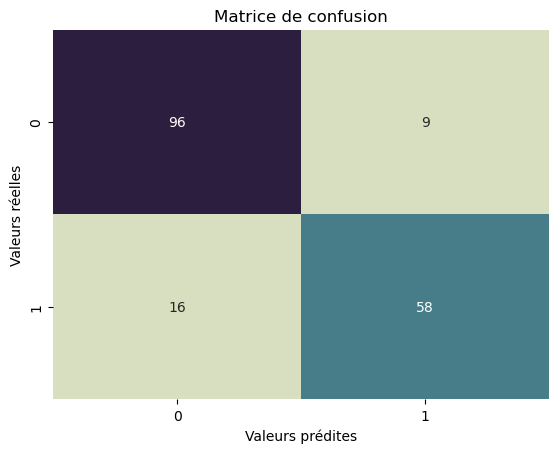

In [224]:
matrix = confusion_matrix(target_test2, target_pred4)

sns.heatmap(matrix, annot = True, cbar = False, cmap =sns.cubehelix_palette(start=.5, rot=-.75))
plt.title("Matrice de confusion")
plt.ylabel("Valeurs réelles")
plt.xlabel("Valeurs prédites")

**Commentaires :** 

Nous constatons un meilleur score de performance globale (f1_score = 0.82) avec le model 4. Rappelons que les variables catégorielles de ce modèle sont des variables binaires. Nous choisirons donc ce modèle pour éffectuer nos prédictions